In [2]:
# Importando as bibliotecas que iremos utilizar:
from nltk import word_tokenize #ja é um modulo pronto para twitter
import nltk #biblioteca com ferramentas para trabalhar com textos
import re #modulo para fazer a limpeza dos dados
import pandas as pd #biblioteca pandas para trabalharmos melhor com a base de dados
from sklearn.feature_extraction.text import CountVectorizer #modulo de vetorização dos tweets
from sklearn.naive_bayes import MultinomialNB #modelo de machine learn que iremos utilizar
from sklearn import svm #outro modelo de machine learn para utilizarmos como base
from sklearn import metrics #modulo de metrificação(?) para compararmos nosso resultado
from sklearn.model_selection import cross_val_predict #modulo de validação para cruzar o modelo com o padrão fornecido
%matplotlib inline

In [3]:
# Lendo a base de dados:
df = pd.read_csv('Dados/Tweets_Mg.csv', encoding='utf-8')

In [4]:
# Visualizando os dados:
df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# a base de dados ja possui uma classificação do comentario para utilizarmos como base,
# principalmente na hora de avaliar o nosso modelo
df.Classificacao.value_counts() 

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

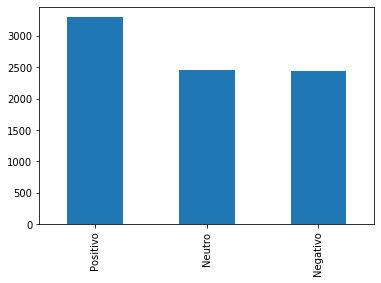

In [6]:
# Visualizando esses dados graficamente:
df.Classificacao.value_counts().plot(kind='bar')

In [7]:
#contando o tamanho da base de dados
df.count()

Unnamed: 0                   8199
Created At                   8199
Text                         8199
Geo Coordinates.latitude      104
Geo Coordinates.longitude     104
User Location                5489
Username                     8199
User Screen Name             8199
Retweet Count                8199
Classificacao                8199
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [8]:
#retirando tweets repetidos e retweetados
df.drop_duplicates(['Text'], inplace = True)

In [9]:
#Recontagem
df.Text.count() #podemos ver que nosso df diminuiu bastante

5765

In [10]:
#separando tweets e suas classificações
tweets = df['Text']
classes = df['Classificacao']

In [11]:
#download dos dicionarios lexicos de palavras
import nltk
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Funções que iremos ou não utilizar

In [12]:
# Função para remover Stopwords da nossa base. Exemplos A, E, I, O, artigos, etc
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords] #comando responsavel por tirar as stopwords das frases
    return (" ".join(palavras))

In [13]:
# Aplicando o stemming em nossa base. Essa função reduz as palavras ao seu sulfixo ex: frequentemente, frequentou, frequentava = frequente
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [14]:
# remove links, pontos, virgulas,ponto e virgulas dos tweets
def Limpeza_dados(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

In [15]:
#mais um stemming de palavras, porem não funciona em portugues esta aqui apenas para fins de estudo.
from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

def Lemmatization(instancia):
  palavras = []
  for w in instancia.split():
    palavras.append(wordnet_lemmatizer.lemmatize(w))
  return (" ".join(palavras))

# Entenda como cada função funciona

In [16]:
RemoveStopWords('Eu não gosto do partido, e tambem não votaria novamente nesse governante!')

'Eu gosto partido, tambem votaria novamente nesse governante!'

In [17]:
Stemming('Eu não gosto do partido, e tambem não votaria novamente nesse governante!')

'eu não gost do partido, e tamb não vot nov ness governante!'

In [18]:
Limpeza_dados('�� @ Governador Valadares, Minas Gerais https:uol.com.br')

'�� @ governador valadares, minas gerais '

In [19]:
Lemmatization('Os carros são bonitos')

'Os carros são bonito'

In [20]:
#podemos fazer uma função com as 4 funções anteriores funcionando juntas
def Preprocessing(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [21]:
tweets[:10] #Antes

0    ���⛪ @ Catedral de Santo Antônio - Governador ...
1    � @ Governador Valadares, Minas Gerais https:/...
2    �� @ Governador Valadares, Minas Gerais https:...
3                          ��� https://t.co/BnDsO34qK0
4    ��� PSOL vai questionar aumento de vereadores ...
5    " bom é bandido morto"\nDeputado Cabo Júlio é ...
6    "..E 25% dos mineiros dizem não torcer para ti...
7    "A gigantesca barba do mal" em destaque no cad...
8    "BB e governo de Minas travam disputa sobre de...
9    "com vcs bh fica pequena!" Belo Horizonte (pro...
Name: Text, dtype: object

In [ ]:
tweets = [Preprocessing(i) for i in tweets] #aplica a função em todos os dados.

In [ ]:
tweets[:10] #Depois

# Tolkenização

In [ ]:
#tolkenização consiste em separar as paralavras em letras para tentar filtrar o uso não padrão da linguagem do twitter.
#Exemplo: ‘@Pedro A Fiap é Legal :) :)’
#Vai ficar: ['@','Pedro',','','A','fiap','é','legal',':',')',':',')']
from nltk.tokenize import word_tokenize #importa a biblioteca de tokenização do NLTK
frase = '@Pedro, a fiap é legal :) :)'
word_tokenize(frase)

In [ ]:
#porem na biblioteca nltk existe um tokenizador proprio para tweeter.
from nltk.tokenize import TweetTokenizer

In [ ]:
#devemos intancia-lo como objeto
tweet_tokenizer = TweetTokenizer()

In [ ]:
tweet_tokenizer.tokenize(frase) #Repare que os emoticons ficam juntos facilitando a analise do sentimento.

# Criando o modelo para classificar os tweets em positivo, negativo ou neutro.

In [ ]:
# Instancia o objeto que faz a vetorização dos dados de texto e compara com os seguintes dados:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize) #ja estamos passando o tokenizador que queremos que ele utilize
# Ou seja esse programa faz a leitura da frase e a transforma palavas em colunas comparando com as frases da segunda linha
# e assim sucessivamente.
#exemplo:1º frase-  @Pedro A fiap é legal
                   #   1   1  1   1   1  
        #2º frase - @joão eu estudo na fiap    #compara a primeira frase com a segunda
        #              0   0    0    0  2
        #3º frase - @Maria eu não estudo na fiap #compara a segunda fase com a terceira
        #              0    1   0    1    1   3


In [ ]:
#assim podemos criar um frequencia de palavras chave
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets) #repare que ele forma uma matrix

In [ ]:
#vamos checar o tamanho dessa matrix
freq_tweets.shape #(cada palavra da nossa base virou uma coluna)

# Treino do modelo Machine Learn

In [ ]:
#Agora que ja vetorizamos os dados vamos treinar o modelo de machine learn que iremos utilizar
modelo = MultinomialNB()
modelo.fit(freq_tweets, classes) #nesta função iremos passar as matriz e as classes

In [ ]:
freq_tweets.A #vamos verificar como esta nossa matrix

In [ ]:
#vamos fazer um teste com nosso modelo 
# Defina instâncias de teste dentro de uma lista:
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

In [ ]:
# Transforma os dados de teste em vetores de palavras:
freq_testes = vectorizer.transform(testes)

In [ ]:
# Fazendo a classificação com o modelo treinado:
for t, c in zip (testes,modelo.predict(freq_testes)):
    # t representa o tweet e c a classificação de cada tweet.
    print (t +", "+ c) 

In [ ]:
# O algoritimo trabalha determinando as probabilidades de cada classe:
print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

# Tags de Negações
Acrescenta uma tag _NEG encontrada após um ‘não’.
Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
Exemplos:
Eu gosto de cachorros, positivo.
Eu não gosto de cachorros, negativo.

In [ ]:
# Função para aplicar as tags de negação:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

In [ ]:
Exemplo com negação
marque_negacao('Eu nao gosto do partido e tambem não votaria novamente nesse governante!') #O resultado ajudará o moledo de machine learn a ser mais preciso


In [ ]:
#exemplo sem negação
marque_negacao('Eu gosto do partido, e tambem votaria novamente nesse governante!')

# Criando modelos com Pipelines
Pipelines são interessantes para reduzir código e automatizar fluxos.
Pipeline são objetos que encadeiam funções para nós facilitando sua vida

In [ ]:
# Vetorizando os dados e passando o classificador:
from sklearn.pipeline import Pipeline
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),#vetoriza os dados em matrix
  ('classifier', MultinomialNB())#classifica a matrix
])

In [ ]:
pipeline_simples.fit(tweets,classes)#treinando o modelo

In [ ]:
#pipeline com negação inclusa
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [ ]:
pipeline_negacoes.fit(tweets, classes) #treinando o modelo

In [ ]:
# Pipeline simples com kernel svs para comparação do modelo
pipeline_svm_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

In [ ]:
# Pipeline com tag de negação e kernel svs para comparação do modelo
pipeline_svm_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

In [ ]:
# Fazendo o cross validation do modelo vai separar o modelo em 10 partes distintas e testar: pipeline simples, tweet(dados), classes, qtd de validaçãos
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)

In [ ]:
# função para determinar a acuracia do modelo: cruza os resultados obtidos com os resultados fornecidos originalmente na tabela
metrics.accuracy_score(classes,resultados)

In [ ]:
# Medidas de validação do modelo: cruza os resultados obtidos com os resultados fornecidos originalmente na tabela
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

In [ ]:
# Matriz de confusão: cruza os resultados obtidos com os resultados fornecidos originalmente na tabela
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

In [ ]:
# Função para automatizar todo o processo acima:
def Metricas(modelo, tweets, classes): #Modelo que iremos analizar, tweets, classes
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return 'Acurácia do modelo: {}'.format(metrics.accuracy_score(classes,resultados))

In [ ]:
# metricas naive bayes pipeline simples
Metricas(pipeline_simples,tweets,classes)

In [ ]:
# metricas naive bayes pipeline simples com tag de negacoes:
Metricas(pipeline_negacoes,tweets,classes)

In [ ]:
# SVM linear simples:
Metricas(pipeline_svm_simples,tweets,classes) #podemos notar que a acuracia desse modelo é melhor porem ele é muito mais demorado

In [ ]:
# SVM linear com tag de negacoes:
Metricas(pipeline_svm_negacoes,tweets,classes) #podemos notar que a acuracia desse modelo é melhor porem ele é muito mais demorado pois almenta o numero de processos